# ◢ RecurSeed and EdgePredictMix

This is a reference implementation of our paper, which presents attention maps per image. 
Should you be making use of our work, please cite our paper. 

In [11]:
import os
import cv2
import torch
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

from core import networks

from tools.ai import torch_utils, augment_utils
from tools.general import io_utils, json_utils, time_utils, cv_utils

# Preprocessing

In [18]:
print(torch.cuda.is_available())

True


In [22]:
torch.cuda.device_count()

2

In [12]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transform = augment_utils.Compose([
    augment_utils.Normalize(imagenet_mean, imagenet_std),
    augment_utils.Transpose(),
])

In [13]:
data_dict = json_utils.read_json(f'./data/VOC.json')

class_names = np.asarray(data_dict['class_names'][1:])
colors = cv_utils.get_colors(data_dict)

In [14]:
model = networks.RSEPM(
    'resnet50', data_dict['num_classes']-1, 
    class_fn='sigmoid', output_stride=16, feature_size=256
)

model.eval()
if torch.cuda.is_available():
    model.cuda()

torch_utils.load_model(model, './experiments/models/ResNet50@VOC@RS+EPM@Official/last.pth')

# Inference

In [15]:
# image = Image.open('./resources/2007_009346_Image.png')
image = Image.open('./resources/2008_002536_Image.png')

w, h = image.size

tensor = test_transform({'image': image, 'mask': None})['image']
tensor = torch.from_numpy(tensor)

if torch.cuda.is_available():
    tensor = tensor.cuda()

params = {
    "image": tensor,
    "image_size": (h, w),

    "scales": [1.0, 0.5, 1.5, 2.0],
    "hflip": True,

    "with_decoder": True,

    "same": True,
    "interpolation": "nearest"
}
output_dict = model.forward_with_scales(**params)

pred_class = output_dict['pred_class']
pred_mask = output_dict['pred_mask']

# Postprocessing

In [16]:
conf_th = 0.34 

class_mask = (pred_class >= conf_th).float()
class_mask = class_mask[:, None, None]


seed = torch_utils.normalize(pred_mask[1:] * class_mask)

# Visualization

(319, 500, 3) (319, 500, 3)


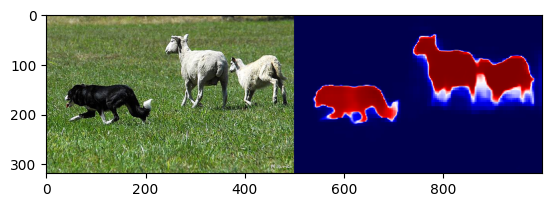

In [17]:
cv_image = np.asarray(image)[..., ::-1]

seed = torch_utils.get_numpy(seed)
seed = cv_utils.apply_colormap(seed)

print(cv_image.shape, seed.shape)

demo = np.concatenate([cv_image, seed], axis=1)

plt.imshow(demo[..., ::-1])